# Recommender Systems

## Collaborative and Content-based Filtering

Recommendation systems are a collection of algorithms used to recommend items to users based on information taken from the user. These systems have become ubiquitous can be commonly seen in online stores, movies databases and job finders. 

In this notebook, we will explore recommendation systems based on Collaborative and Content-based Filtering. In the end we will be able to judge which was best for one specific case.

## The Dataset

This Dataset was acquired from [GroupLens](http://grouplens.org/datasets/movielens/). 

The selected dataset is called ml-latest-small.zip

To acquire and extract the data, simply run the following Bash scripts:

In [1]:
!wget -O ml-latest-small.zip http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
print('unziping ...')
!unzip -o -j ml-latest-small.zip

--2020-04-17 15:09:36--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.04MB/s    in 0.9s    

2020-04-17 15:09:37 (1.04 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

unziping ...
Archive:  ml-latest-small.zip
  inflating: links.csv               
  inflating: tags.csv                
  inflating: ratings.csv             
  inflating: README.txt              
  inflating: movies.csv              


## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

## Reading the files and setting up the dataframes

In [3]:
movies_df = pd.read_csv('movies.csv')  #movies 
ratings_df = pd.read_csv('ratings.csv')  #ratings

**Let's check each dataframe.**

In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


The movies_df dataframe has a unique movie ID for each movies, its title and genres.
The year of release in an information put together with the title. Although we will not use the year of release in our analysis, let's remove it from the title and put it in another column.

In [7]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())

In [8]:
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


For our Content-based filtering system we will need the genres column, but it is not formatted in a way that is useful for us. Let's fix this.

In [9]:
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


Each element in the genres column is a list, but that's not optimal. Let's use One Hot Encoding to transform this information in a way it becomes useful for categorical analysis. We will create a separate dataframe for this, in order to keep the movies dataframe clean.

In [10]:
moviesWithGenres_df = movies_df.copy() #making a copy of the moves dataframe

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies_df.iterrows():
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
moviesWithGenres_df.shape

(9742, 24)

Let's remove the genres column from the movie_df since we stored it in a better configuration on a different dataframe.

In [15]:
movies_df = movies_df.drop('genres',axis=1)

In [16]:
movies_df.head()

,movieId,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


Next, let's look at the ratings dataframe.

In [17]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In the ratings dataframe we have the user ID, the movie ID (same as in the movie dataframe) the rating and the timestamp (when the rating was created by the user). We won't use the timestamp, let's drop it.

In [18]:
ratings_df = ratings_df.drop('timestamp', 1)

In [28]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Let's create one dataframe merging ratings and movies.

In [29]:
df = movies_df.merge(ratings_df,on='movieId')
df

,movieId,title,year,userId,rating
0,1,Toy Story,1995,1,4.0
1,1,Toy Story,1995,5,4.0
2,1,Toy Story,1995,7,4.5
3,1,Toy Story,1995,15,2.5
4,1,Toy Story,1995,17,4.5
...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic,2017,184,4.0
100832,193583,No Game No Life: Zero,2017,184,3.5
100833,193585,Flint,2017,184,3.5
100834,193587,Bungo Stray Dogs: Dead Apple,2018,184,3.5


## Exploratory Data Analysis

In [30]:
df.max()

movieId                                193609
title      À nous la liberté (Freedom for Us)
userId                                    610
rating                                      5
dtype: object

In [31]:
df.min()

movieId      1
title      '71
userId       1
rating     0.5
dtype: object

**Now we know that the maximum is 5 and the minimum is 0.5**.

In [32]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Sorority House Massacre                           5.0
Entertaining Angels: The Dorothy Day Story        5.0
Passenger, The (Professione: reporter)            5.0
Little Dieter Needs to Fly                        5.0
Human Condition III, The (Ningen no joken III)    5.0
Ex Drummer                                        5.0
When Worlds Collide                               5.0
Peaceful Warrior                                  5.0
Eva                                               5.0
Advise and Consent                                5.0
Name: rating, dtype: float64

In [36]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head(15)

title
Forrest Gump                                      329
Shawshank Redemption, The                         317
Pulp Fiction                                      307
Silence of the Lambs, The                         279
Matrix, The                                       278
Star Wars: Episode IV - A New Hope                251
Jurassic Park                                     238
Braveheart                                        237
Terminator 2: Judgment Day                        224
Schindler's List                                  220
Fight Club                                        218
Toy Story                                         215
Star Wars: Episode V - The Empire Strikes Back    211
Usual Suspects, The                               204
American Beauty                                   204
Name: rating, dtype: int64

In [37]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head(10)

,rating
title,
'71,4.000000
'Hellboy': The Seeds of Creation,4.000000
'Round Midnight,3.500000
'Salem's Lot,5.000000
'Til There Was You,4.000000
'Tis the Season for Love,1.500000
"'burbs, The",3.176471
'night Mother,3.000000
(500) Days of Summer,3.666667


In [38]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head(10)

,rating,num of ratings
title,,
'71,4.000000,1
'Hellboy': The Seeds of Creation,4.000000,1
'Round Midnight,3.500000,2
'Salem's Lot,5.000000,1
'Til There Was You,4.000000,2
'Tis the Season for Love,1.500000,1
"'burbs, The",3.176471,17
'night Mother,3.000000,1
(500) Days of Summer,3.666667,42


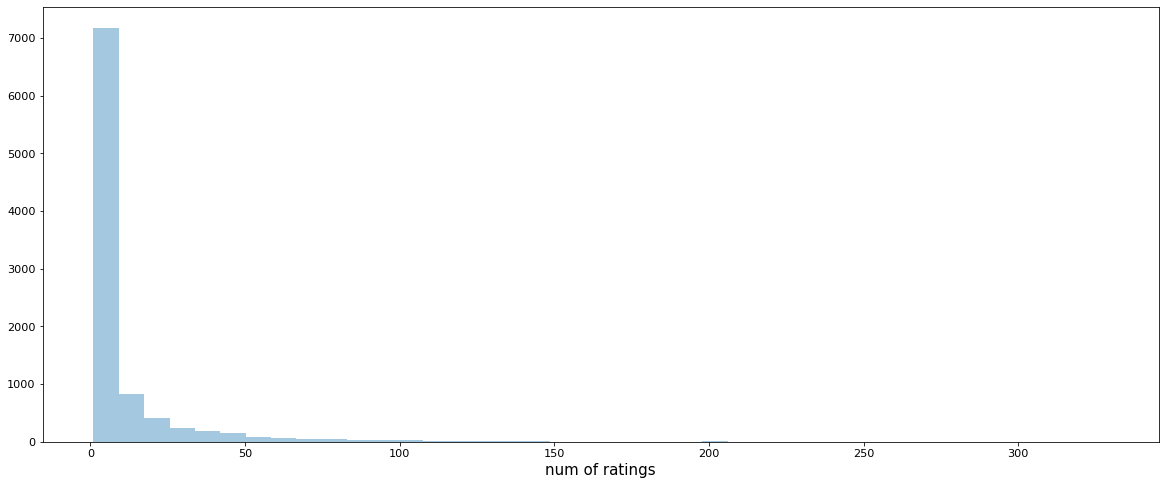

In [50]:
sns.distplot(ratings['num of ratings'],kde=False,bins=40);

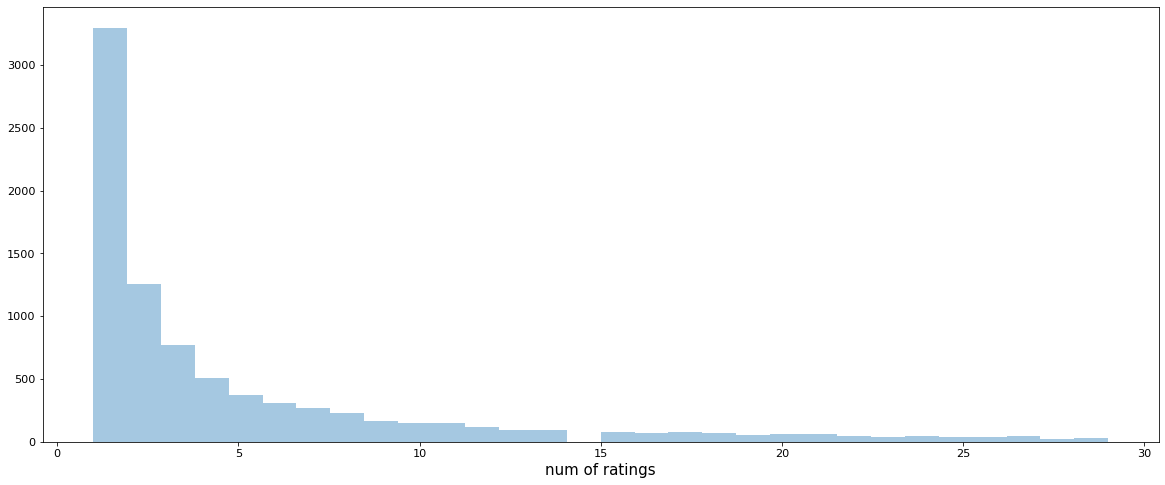

In [51]:
sns.distplot(ratings[ratings['num of ratings'] < 30]['num of ratings'],kde=False,bins=30);

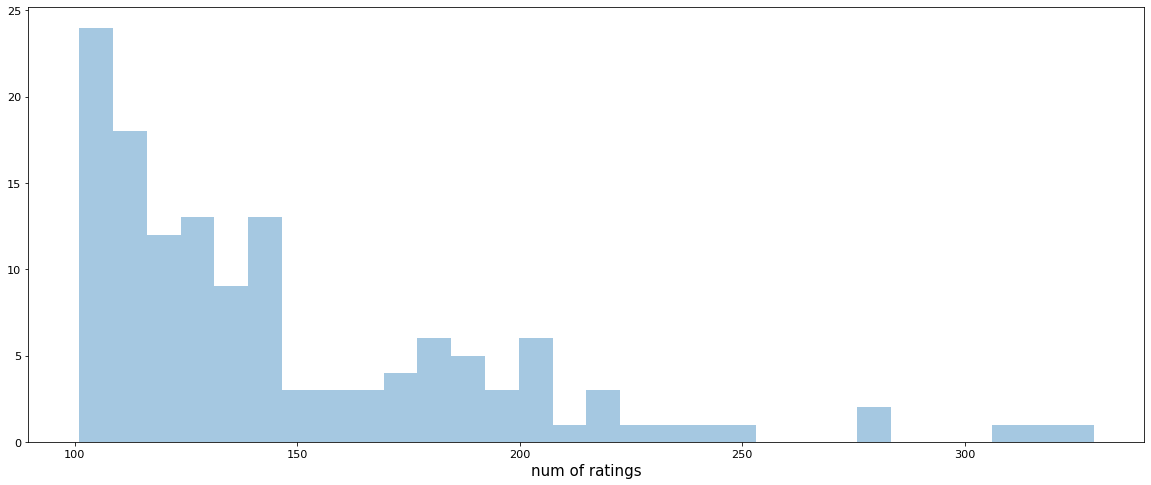

In [52]:
sns.distplot(ratings[ratings['num of ratings'] > 100]['num of ratings'],kde=False,bins=30);

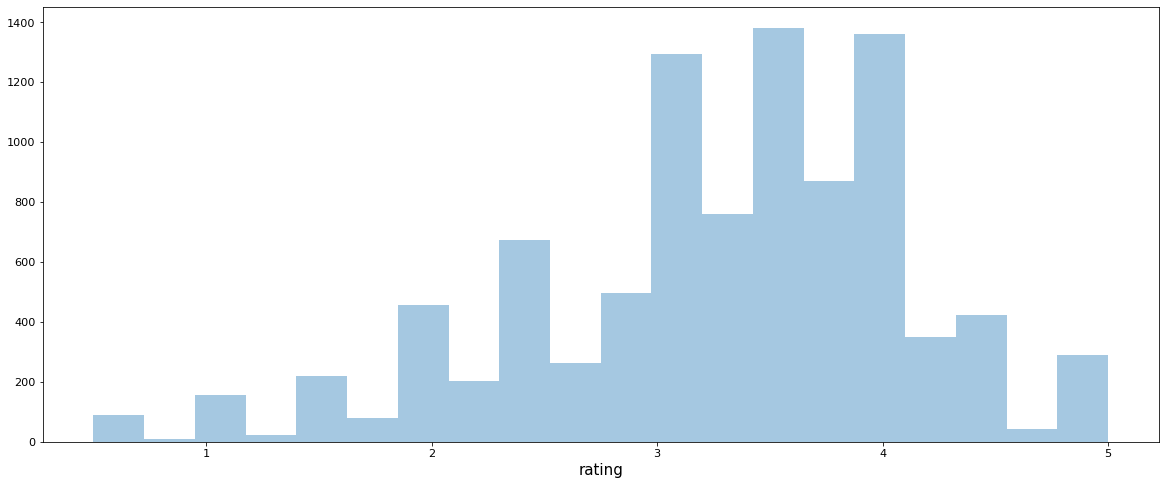

In [55]:
sns.distplot(ratings['rating'],kde=False,bins=20);

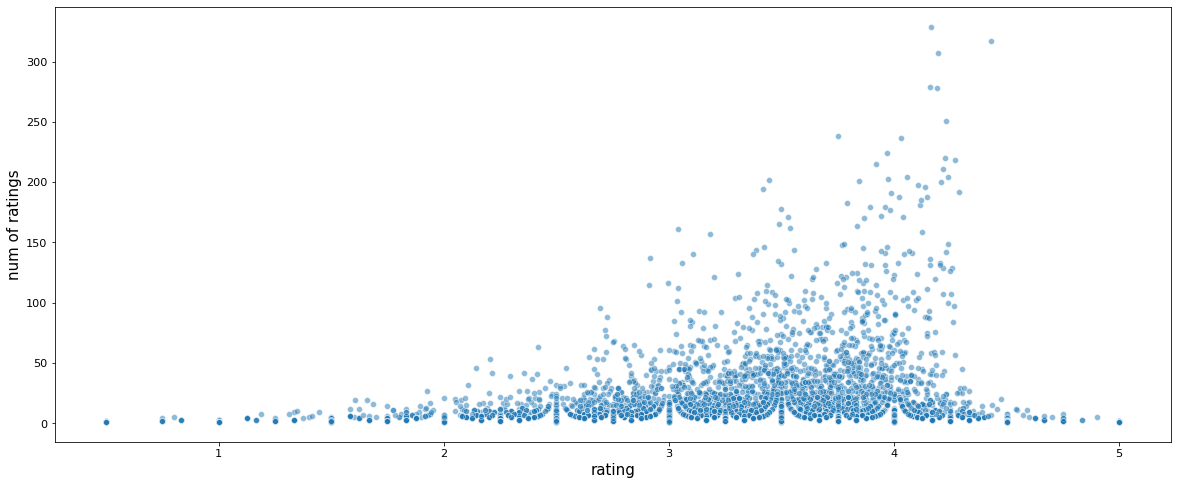

In [58]:
sns.scatterplot(x='rating',y='num of ratings',data=ratings,alpha=0.5);

## Collaborative Filtering

In the Collaborative Filtering,also known as User-User Filtering, we attempt to find users that have similar preferences and opinions as the input user and then recommend items that they have liked to the input user. One way to find user which are similar to the input user is the **Pearson Correlation Function**.

The first step is to create a list of movies rated by the input user.

In [68]:
userInput = [
            {'title':'Matrix, The', 'rating':5},
            {'title':'Star Wars: Episode V - The Empire Strikes Back', 'rating':5},
            {'title':'Forrest Gump', 'rating':4},
            {'title':'Pulp Fiction', 'rating':4},
            {'title':'Silence of the Lambs, The', 'rating':4},
            {'title':'Jurassic Park', 'rating':4.5},
            {'title':'Terminator 2: Judgment Day', 'rating':4},
            {'title':"Schindler's List", 'rating':4.5},
            {'title':'Fight Club', 'rating':5},
            {'title':'Usual Suspects, The', 'rating':4.5},
            {'title':'Indiana Jones and the Last Crusade', 'rating':4.5},
            {'title':'Lord of the Rings: The Fellowship of the Ring, The', 'rating':5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Matrix, The",5.0
1,Star Wars: Episode V - The Empire Strikes Back,5.0
2,Forrest Gump,4.0
3,Pulp Fiction,4.0
4,"Silence of the Lambs, The",4.0
5,Jurassic Park,4.5
6,Terminator 2: Judgment Day,4.0
7,Schindler's List,4.5
8,Fight Club,5.0
9,"Usual Suspects, The",4.5


### Add movieId to input user
With the input complete, let's extract the input movies's ID's from the movies dataframe and add them into it.

In [69]:
#Filtering out the movies by title
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('year', 1)
#Final input dataframe
inputMovies

,movieId,title,rating
0,50,"Usual Suspects, The",4.5
1,296,Pulp Fiction,4.0
2,356,Forrest Gump,4.0
3,480,Jurassic Park,4.5
4,527,Schindler's List,4.5
5,589,Terminator 2: Judgment Day,4.0
6,593,"Silence of the Lambs, The",4.0
7,1196,Star Wars: Episode V - The Empire Strikes Back,5.0
8,1291,Indiana Jones and the Last Crusade,4.5
9,2571,"Matrix, The",5.0


### Get the users who have seen and rated the same movies

In [70]:
#Filtering out users that have watched movies that the input has watched and storing it
userSubset = ratings_df[ratings_df['movieId'].isin(inputMovies['movieId'].tolist())]
userSubset.head()

,userId,movieId,rating
4,1,50,5.0
16,1,296,3.0
20,1,356,4.0
26,1,480,4.0
28,1,527,5.0


We now group up the rows by user ID.

In [74]:
userSubsetGroup = userSubset.groupby(['userId'])
userSubsetGroup.head(10)

,userId,movieId,rating
4,1,50,5.0
16,1,296,3.0
20,1,356,4.0
26,1,480,4.0
28,1,527,5.0
...,...,...,...
99573,610,589,5.0
99575,610,593,4.5
99607,610,1196,5.0
99640,610,1291,4.5


Let's also sort these groups so the users that share the most movies in common with the input have higher priority. This provides a richer recommendation since we won't go through every single user.

In [75]:
#Sorting it so users with movie most in common with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

Now lets look at the first user

In [77]:
userSubsetGroup[0]

(17,
       userId  movieId  rating
 1670      17       50     4.5
 1676      17      296     5.0
 1678      17      356     5.0
 1679      17      480     4.5
 1680      17      527     4.5
 1682      17      589     4.5
 1685      17      593     4.5
 1699      17     1196     5.0
 1717      17     1291     4.0
 1730      17     2571     5.0
 1734      17     2959     4.5
 1745      17     4993     4.5)

We will select a subset of users to iterate through. This limit is imposed because we don't want to waste too much time going through every single user.

In [18]:
#userSubsetGroup = userSubsetGroup[0:100]

Now, we calculate the Pearson Correlation between input user and subset group, and store it in a dictionary, where the key is the user Id and the value is the coefficient


In [79]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorrelationDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='movieId')
    inputMovies = inputMovies.sort_values(by='movieId')
    #Get the N for the formula
    nRatings = len(group)
    #Get the review scores for the movies that they both have in common
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df['rating'].tolist()
    #Let's also put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/np.sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0


In [80]:
pearsonCorrelationDict.items()

dict_items([(17, 0.0), (18, 0.0), (68, 0.4533954695628626), (160, -0.04481107149482209), (182, -0.053300179088902604), (247, 0.09805806756909202), (249, 0.8288038898620531), (274, -0.2631174057921088), (307, -0.3086066999241838), (332, 0.36028834606144683), (391, 0.22086305214969307), (414, 0.21650635094610887), (425, -0.1889822365046136), (474, 0.5492503779276188), (480, 0.0), (561, 0.4107919181288758), (580, 0.17320508075688792), (590, -0.09933992677987843), (606, 0.28474739872574995), (608, 0.48850421045919756), (610, 0.38652605402255524), (28, -0.15463842820677176), (45, 0.2763853991962842), (63, 0.1284252917285223), (64, -0.18540496217739183), (91, 0.5443677129446169), (103, -0.17951515631558787), (177, -0.8147362383430551), (239, 0.5493899055249227), (254, 0.11845088536983592), (279, 0.1788204244096477), (288, -0.3245291187800721), (305, 0.0), (330, -0.1767766952966369), (380, -0.40893731760470237), (387, -0.08597949242859941), (399, 0.06015331289822352), (432, -0.086919186920639

In [81]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,0.000000,17
1,0.000000,18
2,0.453395,68
3,-0.044811,160
4,-0.053300,182


#### The top x similar users to input user
Now let's get the top 50 users that are most similar to the input.

In [82]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
397,1.0,366
453,1.0,430
455,1.0,457
456,1.0,467
446,1.0,375


Now, let's start recommending movies to the input user.

#### Rating of selected users to all movies
We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our __pearsonDF__ from the ratings dataframe and then store their correlation in a new column called _similarityIndex". This is achieved below by merging of these two tables.

In [83]:
topUsersRating=topUsers.merge(ratings_df, left_on='userId', right_on='userId', how='inner')
topUsersRating.head()

,similarityIndex,userId,movieId,rating
0,1.0,366,110,4.0
1,1.0,366,589,4.0
2,1.0,366,1036,4.0
3,1.0,366,1089,5.0
4,1.0,366,2028,4.0


Now all we need to do is simply multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

It shows the idea of all similar users to candidate movies for the input user:

In [84]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,1.0,366,110,4.0,4.0
1,1.0,366,589,4.0,4.0
2,1.0,366,1036,4.0,4.0
3,1.0,366,1089,5.0,5.0
4,1.0,366,2028,4.0,4.0


In [85]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,11.011746,44.410982
2,4.664821,16.152793
3,2.466281,7.373758
6,5.060486,23.110427
7,1.709299,6.627898


In [86]:
#Creates an empty dataframe
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,movieId
movieId,,
1,4.033055,1
2,3.462682,2
3,2.989829,3
6,4.566840,6
7,3.877553,7


Now let's sort it and see the top 20 movies that the algorithm recommended!

In [88]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(20)

,weighted average recommendation score,movieId
movieId,,
68848,5.0,68848
4703,5.0,4703
36517,5.0,36517
3451,5.0,3451
130518,5.0,130518
6385,5.0,6385
5747,5.0,5747
2150,5.0,2150
60766,5.0,60766


In [90]:
movies_df.loc[movies_df['movieId'].isin(recommendation_df.head(20)['movieId'].tolist())]

,movieId,title,year
1427,1950,In the Heat of the Night,1967
1493,2018,Bambi,1942
1553,2090,"Rescuers, The",1977
1608,2150,"Gods Must Be Crazy, The",1980
1630,2176,Rope,1948
1638,2184,"Trouble with Harry, The",1955
1640,2186,Strangers on a Train,1951
1791,2390,Little Voice,1998
1850,2459,"Texas Chainsaw Massacre, The",1974
2582,3451,Guess Who's Coming to Dinner,1967


### From this list I have only seen 5 movies and they are not similar to the input user list. Let's try another filtering method.

## Content-Based recommendation system

This technique attempts to figure out what a user's favourite aspects of an item is, and then recommends items that present those aspects. In our case, we're going to try to figure out the input's favorite genres from the movies and ratings given.

In [91]:
#Filtering out the movies from the input
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
46,50,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
314,356,Forrest Gump,"[Comedy, Drama, Romance, War]",1994,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
418,480,Jurassic Park,"[Action, Adventure, Sci-Fi, Thriller]",1993,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
461,527,Schindler's List,"[Drama, War]",1993,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
507,589,Terminator 2: Judgment Day,"[Action, Sci-Fi]",1991,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
510,593,"Silence of the Lambs, The","[Crime, Horror, Thriller]",1991,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
898,1196,Star Wars: Episode V - The Empire Strikes Back,"[Action, Adventure, Sci-Fi]",1980,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
990,1291,Indiana Jones and the Last Crusade,"[Action, Adventure]",1989,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1939,2571,"Matrix, The","[Action, Sci-Fi, Thriller]",1999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
#Resetting the index to avoid future issues
userMovies = userMovies.reset_index(drop=True)
#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
userGenreTable.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
Adventure,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
Animation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Children,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Comedy,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fantasy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Romance,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Drama,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Action,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
Crime,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Thriller,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [95]:
inputMovies['rating']

0     4.5
1     4.0
2     4.0
3     4.5
4     4.5
5     4.0
6     4.0
7     5.0
8     4.5
9     5.0
10    5.0
11    5.0
Name: rating, dtype: float64

In [96]:
#Dot produt to get weights
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
#The user profile
userProfile

Adventure             19.0
Animation              0.0
Children               0.0
Comedy                 8.0
Fantasy                5.0
Romance                4.0
Drama                 17.5
Action                28.0
Crime                 17.5
Thriller              27.0
Horror                 4.0
Mystery                4.5
Sci-Fi                18.5
War                    8.5
Musical                0.0
Documentary            0.0
IMAX                   0.0
Western                0.0
Film-Noir              0.0
(no genres listed)     0.0
dtype: float64

In [97]:
#Now let's get the genres of every movie in our original dataframe
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId'])
#And drop the unnecessary information
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
genreTable.shape

(9742, 20)

In [99]:
#Multiply the genres by the weights and then take the weighted average
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

movieId
1    0.198142
2    0.148607
3    0.074303
4    0.182663
5    0.049536
dtype: float64

In [100]:
#Sort our recommendations in descending order
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
#Just a peek at the values
recommendationTable_df.head()

movieId
81132    0.777090
71999    0.736842
49530    0.727554
198      0.699690
459      0.699690
dtype: float64

In [101]:
#The final recommendation table
movies_df.loc[movies_df['movieId'].isin(recommendationTable_df.head(20).keys())]

,movieId,title,year
167,198,Strange Days,1995
400,459,"Getaway, The",1994
454,519,RoboCop 3,1993
1978,2625,Black Mask (Hak hap),1996
2248,2985,RoboCop,1987
4176,6016,City of God (Cidade de Deus),2002
5161,8361,"Day After Tomorrow, The",2004
5556,26701,Patlabor: The Movie (Kidô keisatsu patorebâ: T...,1989
5665,27618,"Sound of Thunder, A",2005
6145,43932,Pulse,2006


### This list of recommendations is similar to the one we used as input. Personally, I like this recommendation system.